# Projet détection de langues.

# Les participants:
    Keroudine BELLADJO & Ameline FAVRAIS

En premier lieu, afin que les fonctions puissent fonctionner, il faut importer différentes bibliothèques de pyhton, à savoir:
- Matplotlib qui va nous permettre de visualiser les données (tracer des graphiques)
- Scikit-learn qui propose une implémentation de l’algorithme des k plus proches voisins.
- Pandas qui va nous permettre de traiter nos données
- numpy permet d'effectuer des calculs numériques et introduit une gestion facilitée des tableaux de nombres
- requests Gestion domaines et URLS internationales
- re  permet d'utiliser des expressions régulières avec Python
- BeautifulSoup (belle soup)- BeautifulSoup (belle soup) est une bibliothèque Python d'analyse syntaxique de documents HTML et XML

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import requests
import re
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.neighbors import KNeighborsClassifier

# PARTIE 1

## 1) Création d'un ensemble de données en 5 langues.

On importe des morceaux de texte suffisemment grand pour etre étudié, et de différentes langues afin de pouvoir comparer les caractères par la suite.

- Voici les url du meme texte en 5 langues et leur classe :


In [3]:
url=("https://fr.wikipedia.org/wiki/Martin_Luther_King",
"https://en.wikipedia.org/wiki/Martin_Luther_King_Jr.",
"https://de.wikipedia.org/wiki/Martin_Luther_King",
"https://it.wikipedia.org/wiki/Martin_Luther_King",
"https://es.wikipedia.org/wiki/Martin_Luther_King")
classe=("FR","EN","DE","IT","ES")

- Nous allons définir une fonction "Extraction_de_texte(url)" qui prend en argument un url et mets la contenance de cet url dans un fichier texte et le retourne. Cette fonction nous permetra par la suite de pouvoir traiter la donnée que contient l'url.

In [4]:
def extraction_texte(url):
    """
     Fonction qui prend en argument un url,le traite
     et retourne son contenue
    """
    page=requests.get(url)
    p=BeautifulSoup(page.content,"html.parser")
    resultat=p.find(id="mw-content-text")
    para=resultat.find_all("p")
    l=[]
    for t in para:
        l.append(t.text)
    return " ".join(l)

- On a creer la fonction "texte_sans_c_speciaux" pour filtrer tous les caractères spéciaux et accentués qui sont integrés dans les textes, comme par exemple les parenthèses, en effet cela n'est pas utile de faire une comparaison sur ce genre de caractères et cela la rendra plus précise. On limitera également les textes à 40 000 caractères afin que tout les textes aient le meme nombre de fragments n.

In [5]:
def texte_sans_c_speciaux(t,ind_d_ajstmnt_text=40000):
     
    """Fonction qui prend en argument un fichier texte creer par la fonction precedente et un
    Indice d'ajustement de la longueur du texte et 
    retourne toutes les sous-chaînes qui correspondent à des lettres muniscules ou majuscules du fichier texte"""
    
    texte=t.lower()
    texte=re.findall("[a-z]",texte)
    texte="".join(texte)
    if len(texte)> ind_d_ajstmnt_text:
        texte= texte[0:ind_d_ajstmnt_text]
    else:
        print("Indice d'ajustement de la longueur du texte est trop grand " + str(len(texte)))

    return texte

- Créaction final des textes avec les 2 fonctions précedentes pour les 5 langues.

In [6]:
texte_fr=texte_sans_c_speciaux(extraction_texte(url[0]))
texte_en=texte_sans_c_speciaux(extraction_texte(url[1]))
texte_de=texte_sans_c_speciaux(extraction_texte(url[2]))
texte_it=texte_sans_c_speciaux(extraction_texte(url[3]))
texte_es=texte_sans_c_speciaux(extraction_texte(url[4]))

## 2) Exploration des données.

- Hypothèse: La distribution des caractères varie d'une langue à l'autre.

- Nous allons dans un premier temps étudier la longueur de chaque texte afin de vérifier qu'elle soit bien limité à 40 000 caractères.

In [7]:
len(texte_fr),len(texte_en),len(texte_de),len(texte_es),len(texte_it)

(40000, 40000, 40000, 40000, 40000)

- On peut donc creer un tableur, plus précisement un DataFrame de chacune des 5 langues, qui donnera le nombre d'occurences de chacun des caractères.

In [8]:
V=pd.Series(list(texte_it)).value_counts()
W=pd.Series(list(texte_es)).value_counts()
X=pd.Series(list(texte_fr)).value_counts()
Y=pd.Series(list(texte_en)).value_counts()
Z=pd.Series(list(texte_de)).value_counts()

In [9]:
df= pd.DataFrame(
{"Italien": V,
 "Espagnol": W,
 "Français": X,
"Anglais": Y,
"Allemand": Z})

- On remplacera également les "NaN" par des 0.

In [10]:
df = df.replace(np.NaN, 0, regex=True)
df

,Italien,Espagnol,Français,Anglais,Allemand
a,4304,4728,3169,3276,2396
b,430,621,341,569,727
c,1651,1816,1374,1414,1087
d,1520,2086,1555,1669,1898
e,4523,5004,5618,4719,6604
f,425,345,376,791,676
g,893,610,559,1063,1368
h,454,521,435,2117,1640
i,4578,2885,3212,3239,3219
j,64,200,212,121,115


- On peut ensuite ranger les caractères par nombre d'occurences, par langue, de facon croissante, afin de pouvoir observer lesquelles sont plus fréquentes et lesquelles ne le sont pas. 

In [11]:
df["Français"].sort_values()

z      33
w      44
x     127
k     144
y     171
j     212
b     341
f     376
h     435
q     447
g     559
v     609
p    1075
m    1274
c    1374
d    1555
o    2239
u    2248
l    2406
r    2769
t    3046
a    3169
n    3170
i    3212
s    3347
e    5618
Name: Français, dtype: int64

In [12]:
df["Anglais"].sort_values()

q      26
x      51
z      58
j     121
k     444
v     461
y     537
b     569
p     689
w     723
f     791
u     901
m     988
g    1063
c    1414
l    1572
d    1669
h    2117
s    2481
r    2506
o    2834
n    3102
i    3239
a    3276
t    3649
e    4719
Name: Anglais, dtype: int64

In [13]:
df["Allemand"].sort_values()

q       5
x      27
y     106
j     115
p     362
v     432
z     494
k     623
w     637
f     676
b     727
c    1087
m    1191
o    1262
g    1368
l    1378
u    1434
h    1640
d    1898
a    2396
s    2454
t    2629
r    3134
i    3219
n    4102
e    6604
Name: Allemand, dtype: int64

In [14]:
df["Espagnol"].sort_values()

w      42
x      52
z     140
k     156
j     200
q     261
f     345
y     385
v     418
h     521
g     610
b     621
p     911
m    1094
u    1504
c    1816
t    1826
d    2086
l    2366
r    2674
i    2885
s    2941
n    3082
o    3332
a    4728
e    5004
Name: Espagnol, dtype: int64

In [15]:
df["Italien"].sort_values()

x      15
j      64
w      83
y     115
q     116
k     177
z     401
f     425
b     430
h     454
v     766
g     893
p    1020
m    1059
u    1113
d    1520
c    1651
s    1949
t    2567
l    2580
r    2613
n    3183
o    3401
a    4304
e    4523
i    4578
Name: Italien, dtype: int64

# Partie 2 :

## Représentation des données.

- Contruction d'un diagrame en baton pour avoir la dispersion des caractères pour chaque langue afin de determiner ceux qui sont les plus fréquents et les plus dicriminants d'une langue à l'autre.
- Il nous permettra par la suite de determiner les caractères que nous allons utilisés pour notre ensemble d'entrainement que nous allons nommé "d" par la suite

<AxesSubplot:>

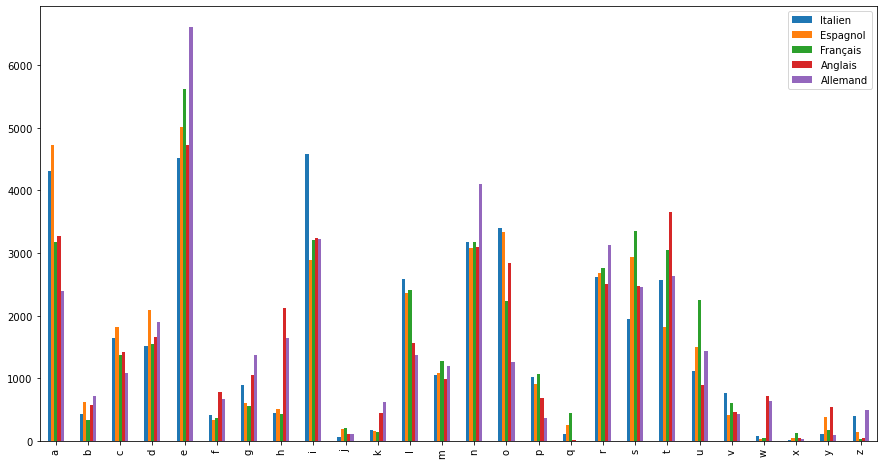

In [16]:
df.plot(kind='bar',figsize=[15,8])

- L'hypothèse est vérifiée, on peut observer à travers ce graphique que la distribution des caractères varie d'une langue à l'autre.
- On pourra donc s'en servir pour faire de la détection de langues.
- On va donc faire de l'exploration de données pour tester cette hypothèse:
    - quels sont les différents caractères utilisés dans les différentes langues?
    - quelle est la fréquence d'apparition de chacun des caractères?


- On choisi donc un d en fonction des caractères les plus fréquents et discriminants. Ici on prendra les 4 caractères les plus présents dans chacune des langues. Ce qui répondra à notre première question.

In [17]:
d=['a', 'e', 'n', 'u', 'p', 'i', 's', 'w','o', 'l', 'h','y','b','r','j','t'] 

## Constitution d'un ensemble d'entraînement.

## 1) Fragmentation des textes.

- Afin d'avoir un résultat cohérent, on a prit comme l_min la racine carré de la longueurs des textes, ce qui donne donc l_min = 200. Cette manière de faire permet d'avoir une même taille de fragment pour tou le texte, ainsi cela permetra d'avoir une meilleurs precision pour la prediction de la langue.

In [18]:
l_min=math.ceil(np.sqrt(40000))

In [19]:
l_min

200

- La fonction que nous allons definir maintenant appelée "les_fragment_du_texte(url,l_min)"  va nous permetre de découper les textes récoltés dans l'étape précédente en fragments de textes qui seront les entrées d'un classifieur (ici l'algo de Knn)
    - On dipose du meme texte en 5 langues: Français,Anglais,Allemand,Italien,Espagnol. 
    - Pour chaque texte, on le découpe par defaut en l_min=200 par morceaux pour avoir un total de n=N//l_min=200 fragments avec N la longueur du texte. 
    - Pour chaque entrée, on calcule la frequence de chaque caractère.
    - N est suffisamment grand (N=40000) pour chaque texte pour ne pas avoir des fragments beaucoup trop petits
    - On a chosi par defaut l_min ou la longueur de fragemnt egale 200 parce qu'il semble plus interesant (peut minimiser le plus possible le risque empirique et en generalisation), c'est en effet notre l_min choisi, nous veront par la suite si notre intuition est juste.

In [20]:
def les_fragment_du_texte(url,l_min=200):
    """Prend en argument un url et l_min la longeur des fragment et
    retourne le texte fragmenté  sous forme d'une liste de n fragment de longueur l_min 
    """
    texte=texte_sans_c_speciaux(extraction_texte(url))
    N=len(texte)
    n=N//l_min
    l=[]
    while n>0:
        n=n-1
        l.append(texte[:l_min])
        texte=texte[l_min:]
    return l

- Obtention des textes fragmenter des 5 langues.

In [21]:
frag_fr=les_fragment_du_texte(url[0],l_min)
frag_en=les_fragment_du_texte(url[1],l_min)
frag_de=les_fragment_du_texte(url[2],l_min)
frag_es=les_fragment_du_texte(url[3],l_min)
frag_it=les_fragment_du_texte(url[4],l_min)

In [22]:
len(frag_fr),len(frag_en),len(frag_de),len(frag_es),len(frag_it)

(200, 200, 200, 200, 200)

- Résultat cohérent; en effet les textes sont tous limités à 40000 caractères et les fragment à 40000/200 = 200

In [23]:
n=len(frag_fr)
n

200

- Conlusion:
    - d = ['a', 'e', 'n', 'u', 'p', 'i', 's', 'w','o', 'l', 'h','y','b','r','j','t'] Lettres les plus fréquentes et discriminantes.
    - l_min = 200. Racine carré de 40 000.
    - N = 40 000. Texte suffisamment grand partagé équitablement en 200 fragments de 200 caractères.
    - n = ⌊N/l_min⌋ = 40 000/200 = 200

## 2) Définition des instance d'apprentissage.

Nous allons definir fonction "frequence(texte,list_of_car)" qui nous permettre de calculer la frequenche de chaque element de notre ensemble "d" dans les fragments du texte. 
Pour chaque entrée, on calcule la fréquence de chaque caracte de notre ensemble "d". On a choisie donc d=['a', 'e', 'n', 'u', 'p', 'i', 's', 'w','o', 'l', 'h','y','b','r','j','t'] par defaut car c'est lui qui minismise nos risques le mieux parmis tous ceux q'on a essayer, nous le demontrerons egalement par la suite

In [24]:
def frequence(texte,list_of_car=d):
    """Création d'une fonction fréquence qui prend en argument un texte et une liste de caractere,
    calcul la frequence de chaque caractere de la liste
    et retourne les frequences calculées sous forme de liste"""
    li=[]
    for c in list_of_car:
        li.append(texte.count(c)/len(texte))
    return li

- Exemple de la fréquence de quelques lettres du texte en francais : 

In [25]:
frequence(texte_fr,["a","s","e","z"])

[0.079225, 0.083675, 0.14045, 0.000825]

- Création de 5 dataframes contenant les fréquences de chaque caractère sur les 200 fragments pour chacune des 5 langues.

la fonction datafrag est une Fonction qui permet de constituer une liste de liste des frequences de caractere de chaque fragment d'un texte. elle nous permtra de pouvoir créer des dataframes pour chaque langue.

In [26]:
def datafrag(url,list_of_car,l_min):
    data=[]
    for frag in les_fragment_du_texte(url,l_min):
        data.append(frequence(frag,list_of_car))
    return data

La fonction que nous allons definir maintenant intitulée "Instances(url,list_of_car=d,l_min,classe)" nous permetra de construire un dataframe. Ce dataframe va etre composé en ligne par la frequence des elements de de l'ensemnbe "d" des diferements frangemnt d'un texte et  en colone par les elemnts de l'ensemble "d" et la classe du fragment.

In [27]:
def instances(url,list_of_car,l_min,classe):
    frag=datafrag(url,list_of_car,l_min)
    data=pd.DataFrame(frag,columns=list_of_car)
    data["Classe"]=classe
    return data

- Dataframme contenant les fréquences de chaque caractère des 200 fragments en Francais :

In [28]:
data_fr=instances(url[0],d,l_min,classe[0])
data_fr

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
0,0.065,0.105,0.065,0.055,0.025,0.105,0.035,0.005,0.075,0.060,0.025,0.010,0.000,0.085,0.005,0.075,FR
1,0.095,0.130,0.100,0.030,0.030,0.100,0.070,0.000,0.050,0.050,0.010,0.000,0.005,0.070,0.005,0.105,FR
2,0.050,0.145,0.070,0.035,0.020,0.080,0.065,0.005,0.090,0.080,0.010,0.010,0.015,0.065,0.000,0.080,FR
3,0.105,0.100,0.090,0.050,0.030,0.085,0.055,0.000,0.060,0.075,0.020,0.010,0.015,0.070,0.010,0.080,FR
4,0.065,0.150,0.040,0.030,0.005,0.085,0.085,0.000,0.040,0.060,0.015,0.000,0.010,0.090,0.005,0.095,FR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.055,0.185,0.070,0.040,0.040,0.065,0.110,0.000,0.060,0.070,0.005,0.005,0.010,0.055,0.005,0.080,FR
196,0.080,0.150,0.100,0.055,0.040,0.075,0.055,0.000,0.065,0.070,0.015,0.005,0.010,0.055,0.005,0.085,FR
197,0.080,0.175,0.080,0.030,0.025,0.070,0.065,0.000,0.060,0.050,0.005,0.005,0.005,0.085,0.005,0.095,FR
198,0.040,0.165,0.115,0.100,0.015,0.100,0.080,0.000,0.055,0.040,0.030,0.000,0.005,0.040,0.025,0.060,FR


- Dataframme contenant les fréquences de chaque caractère des 202 fragments en Anglais :

In [29]:
data_en=instances(url[1],d,l_min,classe[1])
data_en

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
0,0.125,0.085,0.085,0.015,0.020,0.110,0.065,0.010,0.035,0.040,0.040,0.005,0.020,0.070,0.015,0.070,EN
1,0.080,0.080,0.105,0.010,0.005,0.150,0.070,0.005,0.050,0.040,0.060,0.010,0.015,0.045,0.000,0.075,EN
2,0.070,0.105,0.060,0.010,0.020,0.090,0.065,0.000,0.065,0.035,0.055,0.010,0.030,0.085,0.000,0.100,EN
3,0.080,0.150,0.100,0.015,0.020,0.065,0.055,0.010,0.060,0.055,0.065,0.010,0.020,0.050,0.000,0.050,EN
4,0.060,0.145,0.050,0.015,0.035,0.065,0.090,0.020,0.075,0.040,0.065,0.010,0.005,0.060,0.000,0.110,EN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.070,0.125,0.045,0.045,0.010,0.075,0.090,0.020,0.055,0.050,0.040,0.020,0.005,0.075,0.005,0.115,EN
196,0.080,0.110,0.065,0.030,0.020,0.105,0.055,0.020,0.100,0.060,0.035,0.000,0.010,0.065,0.000,0.095,EN
197,0.075,0.100,0.075,0.050,0.020,0.080,0.040,0.025,0.090,0.035,0.045,0.015,0.005,0.080,0.005,0.095,EN
198,0.050,0.120,0.060,0.015,0.025,0.120,0.060,0.010,0.065,0.030,0.055,0.000,0.010,0.070,0.005,0.105,EN


- Dataframme contenant les fréquences de chaque caractère des 202 fragments en Allemand :

In [30]:
data_de=instances(url[2],d,l_min,classe[2])
data_de

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
0,0.100,0.150,0.095,0.030,0.025,0.085,0.055,0.010,0.010,0.045,0.030,0.000,0.010,0.120,0.015,0.070,DE
1,0.050,0.185,0.075,0.040,0.015,0.075,0.045,0.015,0.020,0.015,0.035,0.000,0.015,0.125,0.005,0.065,DE
2,0.080,0.135,0.130,0.030,0.015,0.090,0.085,0.010,0.020,0.035,0.030,0.000,0.005,0.070,0.000,0.075,DE
3,0.050,0.180,0.090,0.045,0.000,0.065,0.080,0.030,0.015,0.030,0.060,0.000,0.015,0.075,0.000,0.055,DE
4,0.060,0.170,0.100,0.020,0.015,0.110,0.075,0.015,0.020,0.050,0.050,0.000,0.015,0.085,0.000,0.060,DE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.060,0.160,0.085,0.055,0.015,0.070,0.055,0.015,0.025,0.040,0.050,0.000,0.015,0.105,0.005,0.045,DE
196,0.055,0.150,0.085,0.035,0.010,0.075,0.065,0.015,0.020,0.030,0.065,0.000,0.015,0.075,0.000,0.065,DE
197,0.090,0.125,0.095,0.045,0.020,0.085,0.085,0.015,0.035,0.045,0.055,0.000,0.015,0.070,0.005,0.045,DE
198,0.040,0.120,0.100,0.035,0.005,0.115,0.085,0.015,0.050,0.035,0.020,0.005,0.005,0.075,0.000,0.085,DE


- Dataframme contenant les fréquences de chaque caractère des 202 fragments en Italien :

In [31]:
data_it=instances(url[3],d,l_min,classe[3])
data_it

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
0,0.100,0.110,0.075,0.025,0.035,0.125,0.050,0.0,0.075,0.055,0.015,0.000,0.000,0.065,0.010,0.115,IT
1,0.135,0.090,0.075,0.025,0.030,0.120,0.030,0.0,0.085,0.075,0.015,0.000,0.000,0.060,0.000,0.075,IT
2,0.110,0.100,0.100,0.030,0.020,0.120,0.045,0.0,0.070,0.065,0.020,0.000,0.015,0.055,0.005,0.080,IT
3,0.130,0.135,0.090,0.015,0.025,0.105,0.055,0.0,0.070,0.070,0.010,0.000,0.015,0.065,0.000,0.080,IT
4,0.150,0.115,0.080,0.015,0.025,0.120,0.070,0.0,0.075,0.070,0.005,0.000,0.000,0.055,0.000,0.065,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.120,0.105,0.085,0.010,0.020,0.090,0.040,0.0,0.110,0.050,0.005,0.015,0.015,0.075,0.000,0.060,IT
196,0.130,0.115,0.075,0.020,0.020,0.110,0.055,0.0,0.075,0.065,0.025,0.005,0.000,0.065,0.000,0.055,IT
197,0.090,0.130,0.055,0.050,0.020,0.105,0.045,0.0,0.090,0.065,0.015,0.000,0.000,0.080,0.000,0.105,IT
198,0.115,0.125,0.090,0.045,0.010,0.090,0.075,0.0,0.075,0.070,0.015,0.000,0.015,0.070,0.000,0.030,IT


- Dataframme contenant les fréquences de chaque caractère des 202 fragments en Espagnol :

In [32]:
data_es=instances(url[4],d,l_min,classe[4])
data_es

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
0,0.115,0.135,0.080,0.045,0.010,0.080,0.065,0.0,0.060,0.060,0.015,0.005,0.015,0.065,0.010,0.070,ES
1,0.135,0.125,0.070,0.020,0.035,0.075,0.080,0.0,0.080,0.035,0.005,0.010,0.005,0.080,0.000,0.055,ES
2,0.140,0.110,0.090,0.045,0.030,0.070,0.060,0.0,0.105,0.060,0.015,0.010,0.015,0.055,0.000,0.035,ES
3,0.155,0.100,0.060,0.025,0.035,0.085,0.080,0.0,0.065,0.040,0.015,0.010,0.015,0.065,0.005,0.035,ES
4,0.095,0.125,0.080,0.035,0.010,0.065,0.105,0.0,0.105,0.050,0.020,0.015,0.015,0.060,0.000,0.055,ES
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.095,0.125,0.095,0.035,0.015,0.100,0.075,0.0,0.050,0.050,0.025,0.010,0.010,0.080,0.005,0.060,ES
196,0.080,0.130,0.090,0.055,0.010,0.075,0.095,0.0,0.100,0.045,0.005,0.005,0.015,0.045,0.015,0.055,ES
197,0.090,0.135,0.115,0.030,0.010,0.090,0.095,0.0,0.075,0.065,0.010,0.015,0.015,0.020,0.000,0.085,ES
198,0.100,0.165,0.125,0.020,0.030,0.060,0.065,0.0,0.065,0.045,0.010,0.015,0.020,0.065,0.010,0.035,ES


- Création d'un dataframme comprenant les 5 dataframmes vu précedemment avec leur classe (concaténation).

La fonction data_instances(l) ci-dessous va nous permetre de concatener les dataframe des differentes langues construit a partir de la fonction "Instances" precedent. Elle permet donc de constituer notre ensemble d'entraînement (instances d'apprentissage) pour l'algo de knn.

In [33]:
def data_instances(l):
    data=pd.concat(l, axis=0)
    data=data.sort_values(by=['Classe'],ascending=False)
    return data

In [34]:
data=data_instances([data_fr,data_en,data_de,data_it,data_es])
data

,a,e,n,u,p,i,s,w,o,l,h,y,b,r,j,t,Classe
1,0.135,0.090,0.075,0.025,0.030,0.120,0.030,0.000,0.085,0.075,0.015,0.000,0.000,0.060,0.000,0.075,IT
137,0.110,0.100,0.060,0.025,0.055,0.130,0.025,0.000,0.080,0.055,0.010,0.000,0.010,0.070,0.000,0.075,IT
127,0.080,0.100,0.045,0.015,0.025,0.165,0.070,0.000,0.080,0.095,0.005,0.000,0.005,0.055,0.000,0.085,IT
128,0.095,0.105,0.065,0.025,0.035,0.110,0.070,0.000,0.085,0.090,0.010,0.005,0.015,0.040,0.005,0.090,IT
129,0.100,0.095,0.040,0.035,0.040,0.125,0.030,0.010,0.090,0.075,0.010,0.005,0.005,0.070,0.000,0.065,IT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,0.085,0.135,0.090,0.040,0.005,0.105,0.050,0.025,0.020,0.015,0.025,0.005,0.040,0.080,0.000,0.060,DE
69,0.050,0.160,0.120,0.060,0.015,0.095,0.040,0.010,0.015,0.020,0.040,0.000,0.010,0.060,0.005,0.070,DE
70,0.050,0.180,0.105,0.025,0.015,0.095,0.050,0.030,0.030,0.045,0.015,0.000,0.010,0.070,0.000,0.090,DE
71,0.055,0.170,0.090,0.030,0.015,0.100,0.060,0.005,0.015,0.040,0.050,0.005,0.020,0.060,0.005,0.095,DE


- Ce dataframme a permit de répondre à notre seconde question et de donner la fréquence de chaque caractère ainsi que leur classe.

# exploré la mesure de la précision du modèle.

## 3) Erreur empirique et en généralisation.

Cet algorithme est utilisé pour résoudre les problèmes du modèle de classification. K-plus proche voisin ou algorithme K-NN crée essentiellement une frontière imaginaire pour classer les données. Lorsque de nouveaux points de données arrivent, l’algorithme essaie de le prédire au plus proche de la ligne de démarcation.



Par conséquent, une valeur k plus élevée signifie des courbes de séparation plus lisses, ce qui donne des modèles moins complexes. Alors qu’une valeur k plus petite a tendance à surajuster les données et à produire des modèles complexes.

 Il est très important d’avoir la bonne valeur k lors de l’analyse de l’ensemble de données pour éviter le surajustement et le sous-ajustement de l’ensemble de données.



En utilisant l’algorithme k-plus proche voisin, nous ajustons les données historiques (ou entraînons le modèle) et prédisons l’avenir.

Nous avons vu comment nous pouvons utiliser l’algorithme K-NN pour résoudre le problème d’machine learning supervisé. Mais comment mesurer la précision du modèle?

 Au lieu de cela, nous effectuons un réglage des hyperparamètres pour choisir la valeur qui donne les meilleures performances.

Mais comment décider de la bonne valeur k pour l’ensemble de données?

- Le module d’apprentissage scikit-learn propose une implémentation de l’algorithme des k plus proches voisins.

- Évaluation :

    - scikit-learn dispose de nombreuses métriques d’évaluation.

    - Començons donc par partager notre échantillon :

In [36]:
X_train, X_test, y_train, y_test = train_test_split(data[d],data["Classe"],test_size=0.4,random_state=11)

- Les paramètres de la fonction train_test_split sont :

    - les données : variables prédictives ici data[d] (les fragments de texte)
    - les données : variable à prédire ici data["Classe"] (les langues)
    - test_size : proportion de l’échantillon consacré au test
    - random_state : graine du générateur aléatoire utilisé pour le découpage

Nous avons maintenant definir la fonction Erreur qui nous permetra de calculer l'erreur empirique et en generalisation pour un k donné. Plus k est faible plus on aura une meilleur precision pour la prediction d'ou l'importance de cette fonction 

In [37]:
def erreur(list_of_car,l_min,k):
    l=[instances(url[0],d,l_min,classe[0]),
       instances(url[1],d,l_min,classe[1]),
       instances(url[2],d,l_min,classe[2]),
       instances(url[3],d,l_min,classe[3]),
       instances(url[4],d,l_min,classe[4])]
    data=data_instances(l)[list_of_car ]
    cible=data_instances(l)["Classe"]
    X_train, X_test, y_train, y_test = train_test_split(data,cible,test_size=0.4,random_state=11)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #Calcul de l'erreur empirique
    yhat_train = knn.predict(X_train) # predition de la langue  
    err_emp = zero_one_loss(yhat_train, y_train) # calcul combien de fois on se trompe dans notre prédiction

    #Calcul  l'erreur en generalisation
    yhat_val = knn.predict(X_test)
    err_gen = zero_one_loss(yhat_val, y_test)

    print("Erreur empirique:", err_emp, 
          "\nErreur en généralisation:", err_gen)

La fonction Entrainement a le même fonctionnement que la fonction precedent sa seule particularité, il propose plusieurs k. Il nous permet d'avoir une liste des k pour en fin choisir celui qui minimise les risques d'erreur (empirique et en generalisation).

In [38]:
def Entrainement(l,n,list_of_car):
    
    data=data_instances(l)[list_of_car ]
    cible=data_instances(l)["Classe"]
    X_train, X_test, y_train, y_test = train_test_split(data,cible,test_size=0.4,random_state=11)
    erreurs = []
    for k in range(1,n):
        # L'entraînement du modèle
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(X_train, y_train) #entrainemnet du monele
        # l'erreur empirique
        yhat_train = knn.predict(X_train) # prediction de la langue 
        err_emp = zero_one_loss(yhat_train, y_train) # calcul combien de fois on se trompe dans notre prédiction
        # l'erreur en generalisation
        yhat_val = knn.predict(X_test)
        err_gen = zero_one_loss(yhat_val, y_test)
        erreurs.append([k, err_emp, err_gen])
        dfErreurs = pd.DataFrame(erreurs, 
                                 columns=["k", "empirique", "generalization"])
    return dfErreurs

La Fonction f est un complement de la fonction "Entrainement". Elle fait la meme chose que cette derniere, elle nous permet tout simplement d'eviter de duppliquer cette fonction a chaque fois qu'on change de parametre.

In [39]:
def f(d,l_min,n):
    l=[instances(url[0],d,l_min,classe[0]),
       instances(url[1],d,l_min,classe[1]),
       instances(url[2],d,l_min,classe[2]),
       instances(url[3],d,l_min,classe[3]),
       instances(url[4],d,l_min,classe[4])]
    dataEr=Entrainement(l,n,d)
    return dataEr

In [41]:
f(d,l_min,20)

,k,empirique,generalization
0,1,0.000000,0.1650
1,2,0.063333,0.1775
2,3,0.063333,0.1375
3,4,0.066667,0.1275
4,5,0.076667,0.1200
5,6,0.071667,0.1225
6,7,0.075000,0.1100
7,8,0.075000,0.1075
8,9,0.075000,0.1000
9,10,0.071667,0.1000


Ici, dans l’exemple ci-dessus, nous créons un graphique pour voir la valeur k pour laquelle nous avons une grande précision.

On trace les courbes des erreurs empirique et en generalisation pour visualiser leurs allure et choisir le plus petit k 

<AxesSubplot:xlabel='k'>

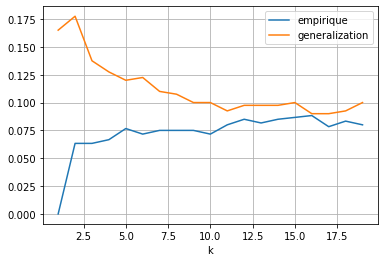

In [42]:
dfErreurs=f(d,l_min,20)
dfErreurs.plot(x="k",grid=True)

- Un classifier 𝑘-plus proches voisins avec 𝑘=19 semble donner le meilleur résultat en terme de généralisation.

In [43]:
erreur(d,l_min,16)

Erreur empirique: 0.08833333333333337 
Erreur en généralisation: 0.08999999999999997


- On chosi donc le k qui minimise l'erreur.

- En prenant le k=19 on observe un erreur moins importante pour l_min = 200

# Appronfondissement.

# 1 er cas étudié: prenons les memes instances mais avec des d et des l_min différents :

Maintenant gardons les memes instances, le meme d, mais prenons l_min=150

<AxesSubplot:xlabel='k'>

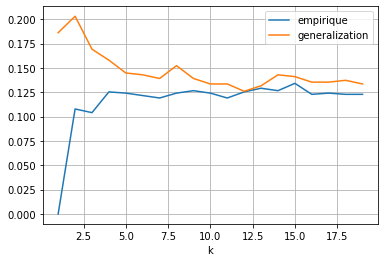

In [41]:
dfErreurs=f(d,150,20)
dfErreurs.plot(x="k",grid=True)

- Un classifier 𝑘-plus proches voisins avec 𝑘=12 semble donner le meilleur résultat en terme de généralisation.
- On observe qu'ici les k sont différents lorsque l_min change.

In [42]:
erreur(d,150,12)

Erreur empirique: 0.12531328320802004 
Erreur en généralisation: 0.12593984962406013


In [43]:
erreur(d,l_min,19)

Erreur empirique: 0.07999999999999996 
Erreur en généralisation: 0.09999999999999998


 - le minimum des k pour l_min=150 est plus elevé que quand l_min=200

Gardons les memes instances, le meme d, mais prenons l_min=250

<AxesSubplot:xlabel='k'>

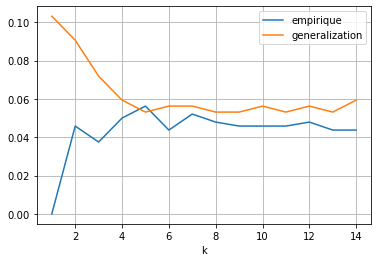

In [44]:
dfErreurs=f(d,250,15)
dfErreurs.plot(x="k",grid=True)

- Un classifier 𝑘-plus proches voisins avec 𝑘=3 semble donner le meilleur résultat en terme de généralisation

In [45]:
erreur(d,250,5)

Erreur empirique: 0.03749999999999998 
Erreur en généralisation: 0.07187500000000002


In [46]:
erreur(d,l_min,19)

Erreur empirique: 0.07999999999999996 
Erreur en généralisation: 0.09999999999999998


- Pour l_min=250 on se trompe moins par raport l_min=200

- On observe donc que selon le l_min l'erreur est plus ou moins importante.

Maintenant changeons simplement d et gardons notre l_min de base.

<AxesSubplot:xlabel='k'>

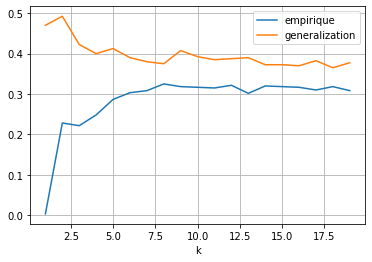

In [52]:
d2=['p','i','t','s']
dfErreurs=f(d2,l_min,20)
dfErreurs.plot(x="k",grid=True)

- Un classifier 𝑘-plus proches voisins avec 𝑘=18 semble donner le meilleur résultat en terme de généralisation.

In [53]:
erreur(d2,l_min,18)

Erreur empirique: 0.31833333333333336 
Erreur en généralisation: 0.365


In [54]:
erreur(d,l_min,19)

Erreur empirique: 0.07999999999999996 
Erreur en généralisation: 0.09999999999999998


- On observe une erreur plus importante pour ce d choisi. 

- Conclusion 1 :
    - Avec les 5 instances on observe que l'erreur devient plus ou moins importante lorsque d ou l_min change.

# 2 ème cas: On compare les erreurs entre 2 langues proches et 2 langues différentes :

Maintenant changeons les instances (uniquement espagnol et italien, langues qui se rapprochent) en gardant le meme l_min et le meme d :

In [55]:
def erreur2(list_of_car,l_min,k):
    l=[instances(url[3],d,l_min,classe[3]),
       instances(url[4],d,l_min,classe[4])]
    data=data_instances(l)[list_of_car ]
    cible=data_instances(l)["Classe"]
    X_train, X_test, y_train, y_test = train_test_split(data,cible,test_size=0.4,random_state=11)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #Calcul de l'erreur empirique
    yhat_train = knn.predict(X_train) # predition de la langue  
    err_emp = zero_one_loss(yhat_train, y_train) # calcul combien de fois on se trompe dans notre prédiction

    #Calcul  l'erreur en generalisation
    yhat_val = knn.predict(X_test)
    err_gen = zero_one_loss(yhat_val, y_test)

    print("Erreur empirique:", err_emp, 
          "\nErreur en généralisation:", err_gen)

In [56]:
def f_es_it(d,l_min,n):
    l=[instances(url[3],d,l_min,classe[3]),
       instances(url[4],d,l_min,classe[4])]
    dataEr=Entrainement(l,n,d)
    return dataEr

<AxesSubplot:xlabel='k'>

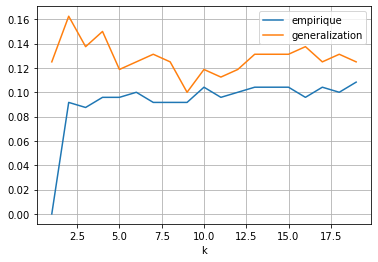

In [57]:
dfErreurs=f_es_it(d,l_min,20)
dfErreurs.plot(x="k",grid=True)

- Un classifier 𝑘-plus proches voisins avec 𝑘=9 semble donner le meilleur résultat en terme de généralisation.

In [58]:
erreur2(d,l_min,9)

Erreur empirique: 0.09166666666666667 
Erreur en généralisation: 0.09999999999999998


In [59]:
erreur(d,l_min,19)

Erreur empirique: 0.07999999999999996 
Erreur en généralisation: 0.09999999999999998


- On constate que pour le cas ou il y a tout les instances l'erreur empirique est moins importante.

Maintenant prenons uniquement francais et allemand ( langue différente ) et comparons avec notre exemple précédent.

In [44]:
def erreur3(list_of_car,l_min,k):
    l=[instances(url[0],d,l_min,classe[0]),
       instances(url[2],d,l_min,classe[2])]
    data=data_instances(l)[list_of_car ]
    cible=data_instances(l)["Classe"]
    X_train, X_test, y_train, y_test = train_test_split(data,cible,test_size=0.4,random_state=11)
    
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    #Calcul de l'erreur empirique
    yhat_train = knn.predict(X_train) # predition de la langue  
    err_emp = zero_one_loss(yhat_train, y_train) # calcul combien de fois on se trompe dans notre prédiction

    #Calcul  l'erreur en generalisation
    yhat_val = knn.predict(X_test)
    err_gen = zero_one_loss(yhat_val, y_test)

    print("Erreur empirique:", err_emp, 
          "\nErreur en généralisation:", err_gen)

In [45]:
def f_fr_de(d,l_min,n):
    l=[instances(url[0],d,l_min,classe[0]),
       instances(url[2],d,l_min,classe[2])]
    dataEr=Entrainement(l,n,d)
    return dataEr

<AxesSubplot:xlabel='k'>

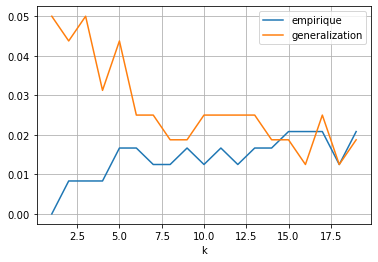

In [46]:
dfErreurs=f_fr_de(d,l_min,20)
dfErreurs.plot(x="k",grid=True)

In [47]:
erreur3(d,l_min,9)

Erreur empirique: 0.01666666666666672 
Erreur en généralisation: 0.018750000000000044


- Un classifier 𝑘-plus proches voisins avec 𝑘=16 semble donner le meilleur résultat en terme de généralisation.

- Conclusion :
    - Lorsque les langues se rapprochent il y a plus d'erreur, en effet cela s'explique par le fait qu'il est difficile de les reconnaitres en sachant qu'elles ont des similitudes.

## Conclusion:

- Il faut donc choisir le l_min, le d, et les instances qui minise les risques; en effet certains cas comme on a pu étudié, comme par exemple en modifiant le domaine instances on remarque des risques d'erreurs plus ou moins  importants.
-les langues les plus proches semble donnée des risques d'erreurs k plus elevés que celles qui ne le sont pas, la prediction pour ces langues est donc moins precises.

- Parmis tous les cas qu'on a pu etudier, le cas où l_min=250 avec d=['a', 'e', 'n', 'u', 'p', 'i', 's', 'w','o', 'l', 'h','y','b','r','j','t']  et n=160 semble donne un meilleurs resultat (le risque d'erreur est beaucoup plus faible)